# **Options Greek Sensitivity Analysis**


Created by Riju Datta

### Introduction

This project explores how the sensitivities of option prices — known as the Greeks — evolve under changing market conditions. Using the Black-Scholes model, we compute and visualize Delta, Gamma, Vega, and Theta across a range of input parameters including the underlying asset price (S), implied volatility (σ), and time to maturity (T). The goal is to build both a **quantitative foundation** and **real-world intuition** for how each Greek behaves across the option lifecycle — both in theory and in practice.

The project combines **simulation-driven exploration** with **real options market data** to provide a comprehensive view.

*Simulation Workflow*
*   Implement the core Black-Scholes pricing and Greeks formulas.
*   Generate synthetic input grids spanning realistic market scenarios for S, σ, and T.
*   Compute each Greek across these grids and visualize their sensitivities using heatmaps, line plots, and 3D surface charts.

*Real-World Extension*
*   Download live or historical option chain data (e.g., via `yfinance`) for a selected ticker (e.g., AAPL, MSFT).
*   Compute Greeks on real contracts using market-observed inputs: strike price, implied volatility, days to expiration, and spot price.
*   Compare calculated values to platform-reported Greeks (if available) and overlay real contracts onto synthetic sensitivity surfaces.

Key outcomes of the project include:
*   A reusable Greek calculator applicable to both synthetic and real-world options.
*   A visual dashboard for analyzing risk exposures by strike, time, and volatility.
*   Practical insights into how option sensitivities evolve under dynamic market conditions.
*   A roadmap for extending this work to live trading strategies, hedging simulations, and real-time risk diagnostics.

## Overview of Options Trading

Options trading is fundamentally about speculating or hedging using contracts whose value derives from an underlying asset.

Key ideas:

**1. An option is a contract**
*   A Call Option gives the right to buy a stock at a fixed price (strike) before expiration.
*   A Put Option gives the right to sell a stock at the strike.

These are rights, not obligations — and they cost money (the premium).

**2. Options trading means betting on probabilities, not just direction**

You're not just betting that a stock will go up or down — you're betting on how much, by when, and how volatile it will be.

Examples:
*   Buy a call: You think the stock will rise a lot before expiry.
*   Sell a put: You think the stock won't fall too much — and want to collect premium.
*   Long straddle: You don't know direction — but expect high volatility.

## Part 1 - Option Data Setup

In this section, we establish two complementary data sources to ground our analysis. First, we generate a synthetic grid of option inputs — underlying asset prices, implied volatilities, and times to maturity — to simulate Greek sensitivities under controlled conditions. Then, we pull real-world options market data using `yfinance`, retrieving full option chains for a chosen ticker and expiration (here, we use MSFT as our ticker.) This real data will serve as the foundation for mapping our theoretical insights onto live market instruments throughout the project.

In [1]:
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the synthetic grid across S, sigma, and T for simulation
sns.set(style="whitegrid")

# --- Fixed parameters ---
K = 100       # Strike price
r = 0.01      # Risk-free interest rate (1%)

# --- Variable ranges ---
S_range = np.linspace(50, 150, 50)       # Underlying asset price
sigma_range = np.linspace(0.1, 0.5, 50)  # Volatility (standard deviation)
T_range = np.linspace(0.01, 1.0, 50)     # Time to expiration (in years)

# --- Grid setup for 3D surface plots ---
S_mesh, sigma_mesh = np.meshgrid(S_range, sigma_range, indexing='ij')
T_mesh, S_mesh_alt = np.meshgrid(T_range, S_range, indexing='ij')  # For time-based surfaces
sigma_mesh_alt, T_mesh_alt = np.meshgrid(sigma_range, T_range, indexing='ij')  # For volatility-based surfaces

# --- Preview ---
print(f"Underlying price range: {S_range[0]} to {S_range[-1]}")
print(f"Volatility range: {sigma_range[0]} to {sigma_range[-1]}")
print(f"Time to expiry range: {T_range[0]} to {T_range[-1]}")

Underlying price range: 50.0 to 150.0
Volatility range: 0.1 to 0.5
Time to expiry range: 0.01 to 1.0


In [3]:
print(S_mesh)
print()
print(sigma_mesh)
print()
print(T_mesh)

[[ 50.          50.          50.         ...  50.          50.
   50.        ]
 [ 52.04081633  52.04081633  52.04081633 ...  52.04081633  52.04081633
   52.04081633]
 [ 54.08163265  54.08163265  54.08163265 ...  54.08163265  54.08163265
   54.08163265]
 ...
 [145.91836735 145.91836735 145.91836735 ... 145.91836735 145.91836735
  145.91836735]
 [147.95918367 147.95918367 147.95918367 ... 147.95918367 147.95918367
  147.95918367]
 [150.         150.         150.         ... 150.         150.
  150.        ]]

[[0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]
 [0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]
 [0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]
 ...
 [0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]
 [0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]
 [0.1        0.10816327 0.11632653 ... 0.48367347 0.49183673 0.5       ]]

[[0.01       0.01       0.01       ... 0.0

In [4]:
# Incorporating real market data (pulled from the yfinance API)
import yfinance as yf

msft_ticker = yf.Ticker("MSFT")
msft_ticker_expiration = msft_ticker.options[0]
msft_opt = msft_ticker.option_chain(msft_ticker_expiration)

Here, we note that .option_chain(msft_ticker_expiration) filters all options expiring on the exact same date (here, May 9, 2025.)

In [5]:
calls = msft_opt.calls
puts = msft_opt.puts

#### Option Chain Column Dictionary

The following table shows a column-by-column description of all the fields within the `calls` dataframe (applies to `puts` as well):

| **Column**            | **Description**                                                                                                                                               |
|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `contractSymbol`       | Ticker of the option contract. Example: `MSFT250509C00225000` →<br> `MSFT` (stock) / `250509` (exp: May 9, 2025) / `C` (call) / `00225000` (strike = 225.00) |
| `lastTradeDate`        | Timestamp of the last trade. Useful to check if the option is active/liquid.                                                                                 |
| `strike`               | Strike price — the fixed price to buy (call) or sell (put) the stock.                                                                                        |
| `lastPrice`            | Last traded price for this contract. May be stale if low liquidity.                                                                                          |
| `bid`                  | Highest price a buyer is willing to pay.                                                                                                                     |
| `ask`                  | Lowest price a seller is willing to accept. Tight bid-ask = more liquid.                                                                                     |
| `change`               | Dollar change in `lastPrice` from previous trading day.                                                                                                      |
| `percentChange`        | Percentage change in `lastPrice` from prior close.                                                                                                           |
| `volume`               | Number of contracts traded today. High volume = better liquidity and trader interest.                                                                        |
| `openInterest`         | Total open positions not yet closed. High OI = high market engagement.                                                                                        |
| `impliedVolatility`    | Market-implied annualized volatility. This is forward-looking, not historical. Crucial for pricing.                                                          |
| `inTheMoney`           | Whether the option has intrinsic value:<br>Calls: `S > strike`<br>Puts: `S < strike`                                                                    |
| `contractSize`         | Typically `REGULAR`, meaning 1 contract = 100 shares.                                                                                                        |
| `currency`             | Currency denomination — usually `USD` for U.S. equities.                                                                                                     |



In [6]:
print(len(calls))

98


In [7]:
print(calls.head())

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  MSFT250516C00220000 2025-05-01 13:34:40+00:00   220.0     216.15  217.30   
1  MSFT250516C00225000 2025-05-02 13:51:23+00:00   225.0     210.50  212.90   
2  MSFT250516C00230000 2025-05-05 17:41:54+00:00   230.0     208.55  207.30   
3  MSFT250516C00240000 2025-05-01 13:31:21+00:00   240.0     195.00  197.35   
4  MSFT250516C00245000 2025-04-16 19:50:00+00:00   245.0     126.25  192.80   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  219.75     0.0            0.0     2.0            20           2.746097   
1  215.40     0.0            0.0     1.0            10           2.335942   
2  210.10     0.0            0.0     1.0           200           2.719730   
3  200.65     0.0            0.0     1.0             8           2.009771   
4  195.00     0.0            0.0     NaN             1           1.839845   

   inTheMoney contractSize currency  
0        True      REGUL

In [8]:
print(puts.head())

        contractSymbol             lastTradeDate  strike  lastPrice  bid  \
0  MSFT250516P00220000 2025-05-01 19:15:46+00:00   220.0       0.01  0.0   
1  MSFT250516P00225000 2025-05-01 13:59:19+00:00   225.0       0.01  0.0   
2  MSFT250516P00230000 2025-05-02 19:59:27+00:00   230.0       0.01  0.0   
3  MSFT250516P00235000 2025-04-24 19:25:07+00:00   235.0       0.03  0.0   
4  MSFT250516P00240000 2025-05-02 14:20:33+00:00   240.0       0.01  0.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  0.01     0.0            0.0    20.0           217           1.562502   
1  0.01     0.0            0.0   180.0          2393           1.531252   
2  0.01     0.0            0.0     1.0          1297           1.468753   
3  0.01     0.0            0.0     NaN            73           1.437503   
4  0.01     0.0            0.0     5.0           265           1.375003   

   inTheMoney contractSize currency  
0       False      REGULAR      USD  
1       False   

## Part 2 - Greek Calculation

In this section, we implement the core quantitative engine for the project — a **modular Greek calculator** based on the Black-Scholes model. We derive and compute the four key first- and second-order sensitivities:

- **Delta** - Rate of change of option value with respect to the underlying asset price (S)
- **Gamma** - Rate of change of Delta with respect to S
- **Vega** - Sensitivity to changes in implied volatility (σ)
- **Theta** - Sensitivity to time decay (T)

This section supports **two data modes**:

1. **Simulated Grid Mode** - We compute Greeks over synthetic ranges of S, σ, and T using NumPy meshgrids to build a smooth surface for visualization and analysis.
2. **Real Market Mode** - We fetch real option chain data from Yahoo Finance using `yfinance`, then apply the same Greek formulas to each contract in the chain based on live inputs like implied volatility, strike, and time-to-expiration.

This dual setup allows us to **validate our formulas** and also **explore how Greeks behave under both theoretical and real-world conditions**.

An additional feature we will include as an optional toggle is to account for **dividend-adjusted option pricing**, where we apply an exponential discount factor using a value *q*, which is the annual dividend yield for the underlying asset.

In [9]:
# These four functions are used to compute the main Greeks for options sensitivity analysis
# (while also accounting for optional dividend yield q)
from scipy.stats import norm

# Delta intuition - "how much the option price changes for a $1 change in the
# underlying asset price"
def delta(S, K, T, r, sigma, option_type, q=0.0):
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

  if option_type == 'call':
    delta = np.exp(-q * T) * norm.cdf(d1)
  elif option_type == 'put':
    delta = -np.exp(-q * T) * (norm.cdf(-d1))
  else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

  return delta

# Gamma intuition - "how sensitive Delta is to changes in the stock price"
def gamma(S, K, T, r, sigma, q=0.0):
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  return (np.exp(-q * T) * norm.pdf(d1)) / (S * sigma * np.sqrt(T))

# Vega intuition - "how much the option price moves if the implied volatility
# changes by 1%"
def vega(S, K, T, r, sigma, q=0.0):
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

# Theta intuition - "how much the option loses in value per day"
def theta(S, K, T, r, sigma, option_type, q=0.0):
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)

  term1 = -(S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
  if option_type == 'call':
    term2 = -r * K * np.exp(-r * T) * norm.cdf(d2)
    term3 = q * S * np.exp(-q * T) * norm.cdf(d1)
  elif option_type == 'put':
    term2 = r * K * np.exp(-r * T) * norm.cdf(-d2)
    term3 = -q * S * np.exp(-q * T) * norm.cdf(-d1)
  else:
    raise ValueError("Invalid option type. Use 'call' or 'put'.")

  return term1 + term2 + term3

### Compare & Contrast: Underlying Price vs. Strike Price

An important distinction in options trading is the underlying asset price (S) and the strike price (K). Below is a table that highlights the distinction between the two:

| Feature                  | Underlying Price (S)                          | Strike Price (K)                              |
|--------------------------|-----------------------------------------------|------------------------------------------------|
| **Definition**           | Current market price of the underlying asset | Fixed price specified in the option contract  |
| **Changes Over Time?**  | Yes — fluctuates in real-time              | No — set when the option is issued          |
| **Set By**               | Market forces (supply/demand)                | Option writer at contract creation             |
| **Used For**             | Determines option value, moneyness, Greeks   | Defines the exercise condition (buy/sell level)|
| **Role in Option Greeks**| Input to all Greek formulas (Δ, Γ, Θ, ν)     | Anchors where Greek sensitivities peak         |
| **Impact on Moneyness**  | Dynamic — moves the option into/out of money | Static — determines in-the-money threshold     |

Now, we compute each of the four primary Greeks (Delta, Gamma, Vega, and Theta) across the synthetic parameter grids defined in Part 1. As mentioned before, these meshgrids simulate realistic combinations of market inputs, such as underlying asset price (S), implied volatility (σ), and time to maturity (T). By evaluating the Greeks over these grids, we generate structured 2D surfaces that reveal how option sensitivities evolve with respect to different market conditions.

In [10]:
print(K)
print(r)

100
0.01


In [11]:
# SIMULATED GRID MODE
# Here, we use all 3 possible meshgrids - S x σ, S x T, and σ x T

# All the matrices below have dimension 50 x 50 (based off of the
# input dimensions of S_mesh/sigma_mesh/T_mesh)

# --- Greeks over S × σ Grid (T fixed at 0.5 years) ---
delta_s_sigma_call = delta(S_mesh, K, 0.5, r, sigma_mesh, option_type='call')
gamma_s_sigma_call = gamma(S_mesh, K, 0.5, r, sigma_mesh)
vega_s_sigma_call  = vega(S_mesh,  K, 0.5, r, sigma_mesh)
theta_s_sigma_call = theta(S_mesh, K, 0.5, r, sigma_mesh, option_type='call')

# --- Greeks over S × T Grid (σ fixed at 0.2) ---
delta_s_t_call = delta(S_mesh_alt, K, T_mesh, r, 0.2, option_type='call')
gamma_s_t_call = gamma(S_mesh_alt, K, T_mesh, r, 0.2)
vega_s_t_call  = vega(S_mesh_alt,  K, T_mesh, r, 0.2)
theta_s_t_call = theta(S_mesh_alt, K, T_mesh, r, 0.2, option_type='call')

# --- Greeks over σ x T (S fixed at 100)
delta_sigma_t_call = delta(100, K, T_mesh_alt, r, sigma_mesh_alt, option_type='call')
gamma_sigma_t_call = gamma(100, K, T_mesh_alt, r, sigma_mesh_alt)
vega_sigma_t_call  = vega(100,  K, T_mesh_alt, r, sigma_mesh_alt)
theta_sigma_t_call = theta(100, K, T_mesh_alt, r, sigma_mesh_alt, option_type='call')

Now, we proceed to visualize each of the Greeks across their respective meshgrids.

In [12]:
!pip install plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [13]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (S × σ)", "Gamma (S × σ)", "Vega (S × σ)", "Theta (S × σ)"]
)

greeks = [delta_s_sigma_call, gamma_s_sigma_call, vega_s_sigma_call, theta_s_sigma_call]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = S_mesh
y = sigma_mesh

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Underlying Price (S)',
            yaxis_title='Volatility (σ)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over S × σ (Calls)",
    height=900,
    width=1000
)

fig.show()

We can confirm that, for the calls option type, the subplots shown above reflect the desired Greek surfaces over a S x σ meshgrid using the following quantitative analyses:
*   For Delta - **As expected, Delta increases monotonically with the underlying price S, approaching 1 as the call option becomes deep in-the-money.** For low S, Delta remains near 0, reflecting minimal sensitivity. The effect of volatility is more pronounced near the at-the-money (ATM) region, where the slope is steepest.
*   For Gamma - **Gamma peaks when S≈K, i.e., at the money, and rapidly decays as the option becomes deep in- or out-of-the-money.** This is consistent with theory: Gamma measures how quickly Delta changes, and this is highest when the outcome of expiring in- or out-of-the-money is most uncertain. The surface flattens at low and high S values.
*   For Vega - **Vega also peaks at-the-money, indicating maximum sensitivity of the option price to changes in volatility when S≈K.** For far in- or out-of-the-money calls, Vega diminishes, since those options have lower time value. The surface increases with volatility initially but eventually flattens, matching expected nonlinear behavior.
*   For Theta - **Theta is negative for calls and becomes steepest around the ATM region, especially as volatility increases.** This captures the fact that time decay accelerates when options are at-the-money and more sensitive to small changes in underlying dynamics. Far out-of-the-money calls show relatively shallow Theta, reflecting lower premium erosion.

In [14]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (S × T)", "Gamma (S × T)", "Vega (S × T)", "Theta (S × T)"]
)

greeks = [delta_s_t_call, gamma_s_t_call, vega_s_t_call, theta_s_t_call]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = S_mesh_alt
y = T_mesh

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Underlying Price (S)',
            yaxis_title='Time to Maturity (T)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over S × T (Calls)",
    height=900,
    width=1000
)

fig.show()

Similar to the previous set of subplots, we can confirm that, for the calls option type, these subplots shown above reflect the desired Greek surfaces over a S x T meshgrid using the following quantitative analyses:
*   For Delta - **Delta increases with S and transitions more sharply from 0 to 1 as time to maturity T decreases.** This reflects how Delta becomes a binary-like indicator near expiry — either 1 for deep ITM calls or 0 for OTM calls - while with more time, there's smoother probabilistic behavior.
*   For Gamma - **Gamma spikes when the option is at-the-money and short-dated (i.e., low T).** This aligns with theory: as expiry nears, even small changes in S can flip an option ITM/OTM, increasing the curvature of the price with respect to S. The surface flattens with longer maturities or deep ITM/OTM positioning.
*   For Vega - **Vega is maximized when the option is at-the-money and has longer time to expiry.** As T→0, Vega collapses, since volatility has little time to affect value. The surface shows the classic dome shape, peaking in the high-T, ATM region and dropping off with moneyness or time decay.
*   For Theta - **Theta is steeply negative for near-expiry, ATM calls, consistent with rapid time decay as expiration approaches.** As T increases, the absolute value of Theta diminishes, reflecting slower erosion of time value. The most extreme decay is clustered around S≈K and T→0, where time premium collapses.

In [15]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (σ × T)", "Gamma (σ × T)", "Vega (σ × T)", "Theta (σ × T)"]
)

greeks = [delta_sigma_t_call, gamma_sigma_t_call, vega_sigma_t_call, theta_sigma_t_call]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = sigma_mesh_alt
y = T_mesh_alt

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Volatility (σ)',
            yaxis_title='Time to Maturity (T)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over σ × T (Calls)",
    height=900,
    width=1000
)

fig.show()

Quantitative analysis of the above 4 subplots:
*   For Delta - **Delta for calls remains strictly positive and ranges from ~0.52 to ~0.61 across the surface.** At-the-money calls (with S ≈ K) tend toward Delta ≈ 0.5, and as volatility or time to maturity increases, Delta gradually rises, reflecting increased probability of finishing in-the-money. The surface is relatively flat but slopes upward gently with both σ and T due to enhanced optionality.
*   For Gamma - **Gamma peaks when both volatility and time to maturity are low, and decays rapidly along both axes.** This aligns with expectations that short-dated, low-volatility options exhibit the sharpest convexity (i.e., sensitivity of Delta to S). The surface shows the typical Gamma decay pattern as extrinsic value increases with σ and T.
*   For Vega - **Vega increases with both volatility and time, forming a smoothly rising convex surface.** As both σ and T increase, the option gains more sensitivity to changes in implied volatility due to its growing time value. The result is a strong Vega buildup in the upper-right region of the surface.
*   For Theta - **Theta is deeply negative across the surface, with the most rapid time decay occurring at high volatility and short time to maturity.** The surface illustrates the severe loss of extrinsic value for volatile options nearing expiry. While the shape is similar to the put surface, Theta is slightly more stable for calls further from expiry due to less downside convexity.



Before we generate the Greeks for the real-world calls and puts dataframes, it would be beneficial to visualize the relevant Greek surfaces when just using the put option type, like we did above.

In [16]:
# --- Greeks over S × σ Grid (T fixed at 0.5 years) ---
delta_s_sigma_put = delta(S_mesh, K, 0.5, r, sigma_mesh, option_type='put')
gamma_s_sigma_put = gamma(S_mesh, K, 0.5, r, sigma_mesh)
vega_s_sigma_put  = vega(S_mesh,  K, 0.5, r, sigma_mesh)
theta_s_sigma_put = theta(S_mesh, K, 0.5, r, sigma_mesh, option_type='put')

# --- Greeks over S × T Grid (σ fixed at 0.2) ---
delta_s_t_put = delta(S_mesh_alt, K, T_mesh, r, 0.2, option_type='put')
gamma_s_t_put = gamma(S_mesh_alt, K, T_mesh, r, 0.2)
vega_s_t_put  = vega(S_mesh_alt,  K, T_mesh, r, 0.2)
theta_s_t_put = theta(S_mesh_alt, K, T_mesh, r, 0.2, option_type='put')

# --- Greeks over σ × T Grid (S fixed at 100)
delta_sigma_t_put = delta(100, K, T_mesh_alt, r, sigma_mesh_alt, option_type='put')
gamma_sigma_t_put = gamma(100, K, T_mesh_alt, r, sigma_mesh_alt)
vega_sigma_t_put  = vega(100,  K, T_mesh_alt, r, sigma_mesh_alt)
theta_sigma_t_put = theta(100, K, T_mesh_alt, r, sigma_mesh_alt, option_type='put')

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (S × σ)", "Gamma (S × σ)", "Vega (S × σ)", "Theta (S × σ)"]
)

greeks = [delta_s_sigma_put, gamma_s_sigma_put, vega_s_sigma_put, theta_s_sigma_put]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = S_mesh
y = sigma_mesh

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Underlying Price (S)',
            yaxis_title='Volatility (σ)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over S × σ (Puts)",
    height=900,
    width=1000
)

fig.show()


Like with the 2 sets of calls plots, we can confirm that, for the puts option type, the subplots shown above reflect the desired Greek surfaces over a S x σ meshgrid using the following quantitative analyses:
*   For Delta - **Put Delta is consistently negative, approaching 0 for far out-of-the-money puts (high S) and -1 for deep in-the-money puts (low S).** As volatility increases, the transition between these regimes becomes smoother, reflecting higher uncertainty.
*   For Gamma - **Gamma remains positive for both calls and puts, peaking near-the-money and when volatility is low.** This symmetry is expected — Gamma reflects convexity of the option price curve, not directionality, and it is shared across calls and puts at the same strike.
*   For Vega - **As with calls, Vega peaks when the option is at-the-money, with lower values for deep ITM/OTM strikes.** The surface is symmetric between calls and puts because Vega reflects sensitivity to volatility and is identical for calls and puts under Black-Scholes.
*   For Theta - **Theta is generally negative across the surface, especially when the option is at-the-money, where time decay is most pronounced.** As volatility increases, Theta becomes more negative due to the option becoming more expensive (higher extrinsic value), leading to greater daily decay. While the analytical form of Theta differs for calls and puts, the dominant term driving the shape — related to the negative contribution from time decay — is similar, producing nearly identical surface geometries under fixed T.

In [18]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (S × T)", "Gamma (S × T)", "Vega (S × T)", "Theta (S × T)"]
)

greeks = [delta_s_t_put, gamma_s_t_put, vega_s_t_put, theta_s_t_put]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = S_mesh_alt
y = T_mesh

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Underlying Price (S)',
            yaxis_title='Time to Maturity (T)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over S × T (Puts)",
    height=900,
    width=1000
)

fig.show()


Similar to the previous set of subplots, we can confirm that, for the puts option type, these subplots shown above reflect the desired Greek surfaces over a S x T meshgrid using the following quantitative analyses:
*   For Delta - **Delta remains negative for puts, ranging from approximately 0 (deep out-of-the-money) to -1 (deep in-the-money).** As the underlying price S drops below the strike, Delta steepens toward -1, indicating increased directional sensitivity. At fixed strike, Delta smoothly transitions across the S-axis and flattens as T increases, since more time dilutes directional certainty.
*   For Gamma - **Gamma peaks sharply near the at-the-money region and diminishes with both deep ITM/OTM conditions and increasing T.** As expected, Gamma is highest for short-dated, ATM options where small changes in price cause large Delta shifts. This plot matches theoretical behavior closely.
*   For Vega - **Vega is highest when options are ATM and increase with longer time to maturity, due to greater exposure to implied volatility risk.** It tapers off for deep ITM/OTM contracts and near expiration. This surface clearly demonstrates that long-dated ATM puts are the most sensitive to changes in volatility.
*   For Theta - **Theta is negative, as expected for long options, and most pronounced for short-dated ATM options, where time decay erodes value quickly.** As maturity increases, Theta's magnitude softens. The plot mirrors the call surface in shape due to the shared structural decay, with differences driven primarily by the sign and distribution skew of payoff profiles.

In [19]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["Delta (σ × T)", "Gamma (σ × T)", "Vega (σ × T)", "Theta (σ × T)"]
)

greeks = [delta_sigma_t_put, gamma_sigma_t_put, vega_sigma_t_put, theta_sigma_t_put]
z_labels = ['Delta', 'Gamma', 'Vega', 'Theta']
x = sigma_mesh_alt
y = T_mesh_alt

for i, greek in enumerate(greeks):
    row, col = divmod(i, 2)
    fig.add_trace(
        go.Surface(
            z=greek,
            x=x,
            y=y,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                title=z_labels[i],
                x=0.46 if (row == 0 and col == 0) else
                  0.95 if (row == 0 and col == 1) else
                  0.46 if (row == 1 and col == 0) else
                  0.95,  # row == 1 and col == 1
                y=0.78 if row == 0 else 0.22,
                len=0.45
            ),
        ),
        row=row+1, col=col+1
    )

# Axis labels for each subplot
for i in range(1, 5):
    fig.update_scenes(
        dict(
            xaxis_title='Volatility (σ)',
            yaxis_title='Time to Maturity (T)',
            zaxis_title=z_labels[i - 1]
        ),
        row=(i - 1)//2 + 1,
        col=(i - 1)%2 + 1
    )

fig.update_layout(
    title_text="Greek Surfaces Over σ × T (Puts)",
    height=900,
    width=1000
)

fig.show()


Final quantitative analysis for these sets of subplots:
*   For Delta - **Delta is consistently negative (as expected for puts), but its magnitude softens as either volatility (σ) or time to maturity (T) increases.** This trend reflects the fact that higher volatility and longer time horizons reduce certainty about the option expiring in-the-money — leading to a flatter Delta (i.e., closer to zero). The most negative Deltas (closest to -0.48) appear when both σ and T are low, meaning the option behaves more like a pure directional bet (deep ITM).
*   For Gamma - **Gamma peaks when both σ and T are low, and decays rapidly along both axes.** This is consistent with Gamma being highest for near-expiry, low-volatility options, where even small price shifts create significant changes in Delta. The sharp spike near the origin captures this instability zone clearly.
*   For Vega - **Vega increases with both volatility and time, forming a convex, upward-sloping surface that peaks in the high-σ, long-T regime.** This matches the theoretical expectation that Vega — i.e., the sensitivity of the option price to changes in implied volatility — is highest when the option has significant extrinsic value. Longer time to expiry and higher σ both amplify this.
*   For Theta - **Theta is steeply negative across the grid, with time decay effects most pronounced when volatility is high and time to maturity is short.** The plot shows a highly convex drop-off in Theta, reaching extreme values near -90 in the high-vol, short-term region. This highlights that volatile, near-expiry options lose time value extremely quickly — especially relevant for short options sellers.

The two code cells below take the plots from above and store them in HTML files (separated by call and put option types) for easier viewing.

In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

# === Call Option Surface Configs ===
call_surface_groups = [
    ("Call Greeks: S × σ", S_mesh, sigma_mesh, [delta_s_sigma_call, gamma_s_sigma_call, vega_s_sigma_call, theta_s_sigma_call]),
    ("Call Greeks: S × T", S_mesh_alt, T_mesh, [delta_s_t_call, gamma_s_t_call, vega_s_t_call, theta_s_t_call]),
    ("Call Greeks: σ × T", sigma_mesh_alt, T_mesh_alt, [delta_sigma_t_call, gamma_sigma_t_call, vega_sigma_t_call, theta_sigma_t_call])
]

greek_names = ["Delta", "Gamma", "Vega", "Theta"]

fig_call = make_subplots(
    rows=3, cols=4,
    specs=[[{'type': 'surface'}]*4]*3,
    subplot_titles=[
        f"{greek} ({label.split(': ')[1]})"
        for label, _, _, _ in call_surface_groups
        for greek in greek_names
    ]
)

for i, (group_title, x_grid, y_grid, surfaces) in enumerate(call_surface_groups):
    for j, Z in enumerate(surfaces):
        fig_call.add_trace(
            go.Surface(
                z=Z, x=x_grid, y=y_grid,
                colorscale='Viridis',
                showscale=False
            ),
            row=i+1, col=j+1
        )
        fig_call.update_scenes(
            dict(
                xaxis_title="S" if "S ×" in group_title else "σ",
                yaxis_title="σ" if "× σ" in group_title else "T",
                zaxis_title=greek_names[j]
            ),
            row=i+1, col=j+1
        )

fig_call.update_layout(
    title_text="Call Option Greek Surfaces (S × σ, S × T, σ × T)",
    height=1800,
    width=1400,
    showlegend=False
)

pio.write_html(fig_call, file="call_surfaces.html", auto_open=False)

In [53]:
# === Put Option Surface Configs ===
put_surface_groups = [
    ("Put Greeks: S × σ", S_mesh, sigma_mesh, [delta_s_sigma_put, gamma_s_sigma_put, vega_s_sigma_put, theta_s_sigma_put]),
    ("Put Greeks: S × T", S_mesh_alt, T_mesh, [delta_s_t_put, gamma_s_t_put, vega_s_t_put, theta_s_t_put]),
    ("Put Greeks: σ × T", sigma_mesh_alt, T_mesh_alt, [delta_sigma_t_put, gamma_sigma_t_put, vega_sigma_t_put, theta_sigma_t_put])
]

fig_put = make_subplots(
    rows=3, cols=4,
    specs=[[{'type': 'surface'}]*4]*3,
    subplot_titles=[
        f"{greek} ({label.split(': ')[1]})"
        for label, _, _, _ in put_surface_groups
        for greek in greek_names
    ]
)

for i, (group_title, x_grid, y_grid, surfaces) in enumerate(put_surface_groups):
    for j, Z in enumerate(surfaces):
        fig_put.add_trace(
            go.Surface(
                z=Z, x=x_grid, y=y_grid,
                colorscale='Plasma',
                showscale=False
            ),
            row=i+1, col=j+1
        )
        fig_put.update_scenes(
            dict(
                xaxis_title="S" if "S ×" in group_title else "σ",
                yaxis_title="σ" if "× σ" in group_title else "T",
                zaxis_title=greek_names[j]
            ),
            row=i+1, col=j+1
        )

fig_put.update_layout(
    title_text="Put Option Greek Surfaces (S × σ, S × T, σ × T)",
    height=1800,
    width=1400,
    showlegend=False
)

pio.write_html(fig_put, file="put_surfaces.html", auto_open=False)

Next, we begin computing the Greeks for call and put options using the real options data we pulled from the `yfinance` API in Part 1. (To clarify, we will need the following real values - the current underlying stock price S, the option strike price K, the time to expiration T in years, the assumed constant risk-free rate r, and the market-implied volatility σ. Optionally, we could also account for the dividend yield q.)

In [22]:
print(msft_opt)

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   MSFT250516C00220000 2025-05-01 13:34:40+00:00   220.0     216.15  217.30   
1   MSFT250516C00225000 2025-05-02 13:51:23+00:00   225.0     210.50  212.90   
2   MSFT250516C00230000 2025-05-05 17:41:54+00:00   230.0     208.55  207.30   
3   MSFT250516C00240000 2025-05-01 13:31:21+00:00   240.0     195.00  197.35   
4   MSFT250516C00245000 2025-04-16 19:50:00+00:00   245.0     126.25  192.80   
..                  ...                       ...     ...        ...     ...   
93  MSFT250516C00540000 2025-05-01 19:54:22+00:00   540.0       0.01    0.00   
94  MSFT250516C00560000 2025-05-09 15:00:51+00:00   560.0       0.01    0.00   
95  MSFT250516C00580000 2025-05-05 13:39:44+00:00   580.0       0.01    0.00   
96  MSFT250516C00600000 2025-05-08 13:44:20+00:00   600.0       0.01    0.00   
97  MSFT250516C00620000 2025-05-09 19:57:26+00:00   620.0       0.01    0.00   

       ask  change  perce

In [23]:
print(msft_ticker_expiration)

2025-05-16


In [24]:
# 1) Compute time to expiration T
from datetime import datetime

expiry = pd.to_datetime(msft_ticker_expiration)
# Generate timestamp for May 7th
date = datetime(2025, 5, 7)
today = pd.to_datetime(date)
days_to_exp = (expiry - today).days + (expiry - today).seconds / (3600 * 24)
T = days_to_exp / 365

print(T)

0.024657534246575342


We only use a single S value for all options because S is the underlying stock price and therefore ISN'T option-specific.

In [25]:
# 2) Define the underlying stock price (S_real)
S_real = yf.Ticker("MSFT").history(period="1d")["Close"].iloc[-1]
print(S_real)

438.7300109863281


Here, we generate the Greeks for the calls dataframe:

In [26]:
# Filter calls such that all remaining rows have positive impliedVolatility values
calls = calls[calls['impliedVolatility'] > 0]

In [27]:
# 3) Apply row-wise operations for Greek calculation using calls DF
# (with .apply and lambda functions)
calls["delta"] = calls.apply(lambda row: delta(
    S_real, row['strike'], T, r, row['impliedVolatility'], 'call'), axis=1)

calls["gamma"] = calls.apply(lambda row: gamma(
    S_real, row['strike'], T, r, row['impliedVolatility']), axis=1)

calls["vega"] = calls.apply(lambda row: vega(
    S_real, row['strike'], T, r, row['impliedVolatility']), axis=1)

calls["theta"] = calls.apply(lambda row: theta(
    S_real, row['strike'], T, r, row['impliedVolatility'], 'call'), axis=1)

calls.head(10)

contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  MSFT250516C00220000 2025-05-01 13:34:40+00:00   220.0     216.15  217.30   
1  MSFT250516C00225000 2025-05-02 13:51:23+00:00   225.0     210.50  212.90   
2  MSFT250516C00230000 2025-05-05 17:41:54+00:00   230.0     208.55  207.30   
3  MSFT250516C00240000 2025-05-01 13:31:21+00:00   240.0     195.00  197.35   
4  MSFT250516C00245000 2025-04-16 19:50:00+00:00   245.0     126.25  192.80   
5  MSFT250516C00250000 2025-05-09 17:21:50+00:00   250.0     186.99  187.50   
6  MSFT250516C00255000 2025-05-02 13:51:23+00:00   255.0     180.55  182.40   
7  MSFT250516C00260000 2025-05-05 15:08:15+00:00   260.0     178.16  177.30   
8  MSFT250516C00265000 2025-04-09 17:20:41+00:00   265.0     113.50  172.40   
9  MSFT250516C00270000 2025-05-08 19:36:00+00:00   270.0     170.82  167.80   

      ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  219.75  0.000000       0.000000     2.0            20           2.746097   
1  215.40  0.000000       0.000000     1.0            10           2.335942   
2  210.10  0.000000       0.000000     1.0           200           2.719730   
3  200.65  0.000000       0.000000     1.0             8           2.009771   
4  195.00  0.000000       0.000000     NaN             1           1.839845   
5  189.75 -4.389999      -2.293865     3.0            29           2.288578   
6  185.20  0.000000       0.000000     1.0             3           1.562502   
7  179.85  0.559998       0.315314     1.0             5           2.181645   
8  175.60  0.000000       0.000000     1.0             2           1.707033   
9  170.30  0.000000       0.000000     5.0            18           1.687502   

   inTheMoney contractSize currency     delta     gamma      vega       theta  
0        True      REGULAR      USD  0.965385  0.000405  5.275218 -295.766248  
1        True      REGULAR      USD  0.977498  0.000332  3.685394 -176.704008  
2        True      REGULAR      USD  0.957852  0.000480  6.194004 -343.676329  
3        True      REGULAR      USD  0.980777  0.000338  3.225274 -133.746016  
4        True      REGULAR      USD  0.984690  0.000304  2.655274 -101.437473  
5        True      REGULAR      USD  0.959542  0.000552  5.991834 -280.357033  
6        True      REGULAR      USD  0.990235  0.000243  1.798413  -59.483734  
7        True      REGULAR      USD  0.955365  0.000627  6.487418 -289.368421  
8        True      REGULAR      USD  0.978088  0.000445  3.603688 -127.283741  
9        True      REGULAR      USD  0.975320  0.000497  3.983161 -138.878069

Now, we generate the Greeks for the puts dataframe:

In [28]:
puts = puts[puts['impliedVolatility'] > 0]

In [29]:
# 4) Apply row-wise operations for Greek calculation using puts DF
# (with .apply and lambda functions)
puts["delta"] = puts.apply(lambda row: delta(
    S_real, row['strike'], T, r, row['impliedVolatility'], 'put'), axis=1)

puts["gamma"] = puts.apply(lambda row: gamma(
    S_real, row['strike'], T, r, row['impliedVolatility']), axis=1)

puts["vega"] = puts.apply(lambda row: vega(
    S_real, row['strike'], T, r, row['impliedVolatility']), axis=1)

puts["theta"] = puts.apply(lambda row: theta(
    S_real, row['strike'], T, r, row['impliedVolatility'], 'put'), axis=1)

puts.head(10)

contractSymbol             lastTradeDate  strike  lastPrice  bid  \
0  MSFT250516P00220000 2025-05-01 19:15:46+00:00   220.0       0.01  0.0   
1  MSFT250516P00225000 2025-05-01 13:59:19+00:00   225.0       0.01  0.0   
2  MSFT250516P00230000 2025-05-02 19:59:27+00:00   230.0       0.01  0.0   
3  MSFT250516P00235000 2025-04-24 19:25:07+00:00   235.0       0.03  0.0   
4  MSFT250516P00240000 2025-05-02 14:20:33+00:00   240.0       0.01  0.0   
5  MSFT250516P00245000 2025-05-01 17:56:30+00:00   245.0       0.02  0.0   
6  MSFT250516P00250000 2025-05-08 17:37:57+00:00   250.0       0.01  0.0   
7  MSFT250516P00255000 2025-05-05 16:58:01+00:00   255.0       0.01  0.0   
8  MSFT250516P00260000 2025-05-08 15:05:15+00:00   260.0       0.02  0.0   
9  MSFT250516P00265000 2025-04-30 17:49:37+00:00   265.0       0.06  0.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  0.01     0.0            0.0    20.0           217           1.562502   
1  0.01     0.0            0.0   180.0          2393           1.531252   
2  0.01     0.0            0.0     1.0          1297           1.468753   
3  0.01     0.0            0.0     NaN            73           1.437503   
4  0.01     0.0            0.0     5.0           265           1.375003   
5  0.01     0.0            0.0    21.0          1061           1.343753   
6  0.02     0.0            0.0    20.0          2126           1.359378   
7  0.01     0.0            0.0     1.0           201           1.250004   
8  0.02     0.0            0.0     1.0           316           1.281254   
9  0.02     0.0            0.0     5.0           444           1.234379   

   inTheMoney contractSize currency     delta     gamma      vega      theta  
0       False      REGULAR      USD -0.001657  0.000050  0.368134 -11.656177  
1       False      REGULAR      USD -0.001875  0.000057  0.411878 -12.780134  
2       False      REGULAR      USD -0.001770  0.000056  0.390855 -11.632546  
3       False      REGULAR      USD -0.001990  0.000064  0.434887 -12.667321  
4       False      REGULAR      USD -0.001848  0.000062  0.406498 -11.325335  
5       False      REGULAR      USD -0.002066  0.000071  0.449918 -12.249841  
6       False      REGULAR      USD -0.003047  0.000099  0.639186 -17.604992  
7       False      REGULAR      USD -0.002093  0.000077  0.455103 -11.525895  
8       False      REGULAR      USD -0.003443  0.000117  0.713401 -18.518770  
9       False      REGULAR      USD -0.003475  0.000123  0.719502 -17.993257

In the plots below, we visualize how each Greek value changes as the strike price varies.

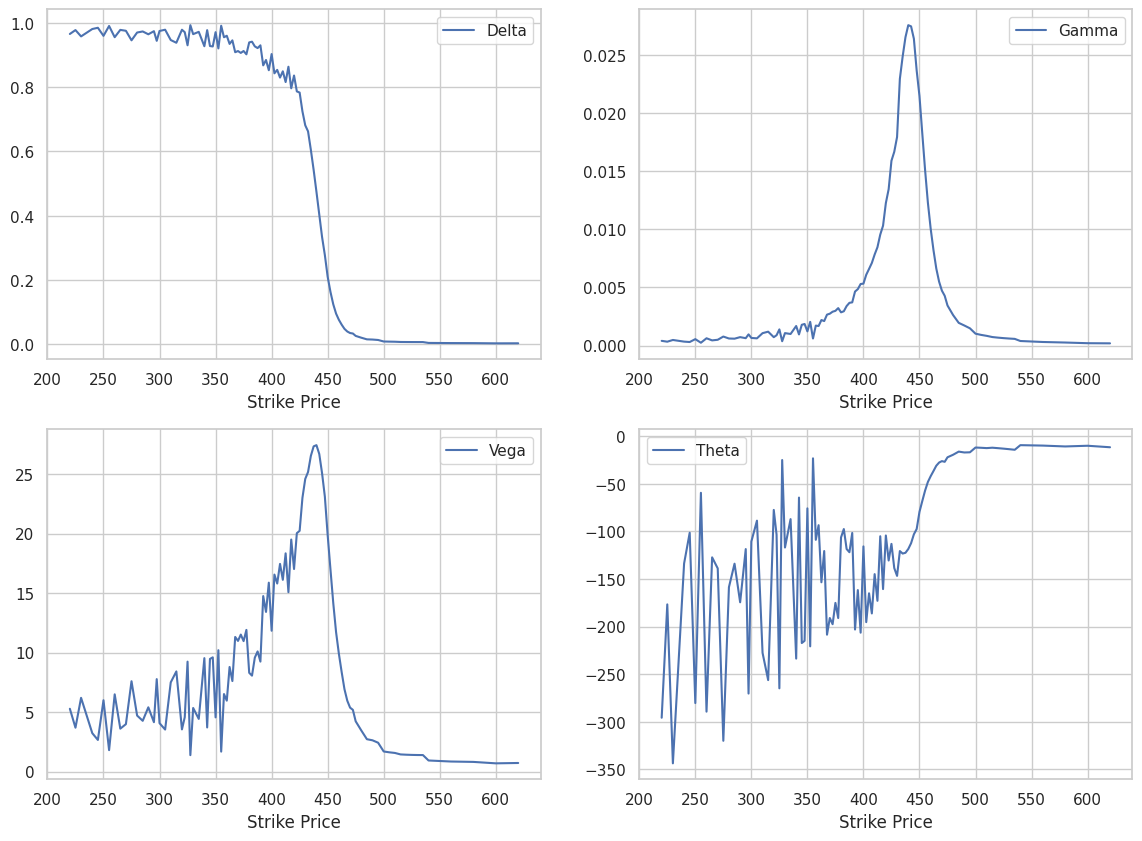

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(calls['strike'], calls['delta'], label='Delta')
axs[0, 1].plot(calls['strike'], calls['gamma'], label='Gamma')
axs[1, 0].plot(calls['strike'], calls['vega'], label='Vega')
axs[1, 1].plot(calls['strike'], calls['theta'], label='Theta')

for ax in axs.flat:
    ax.set_xlabel('Strike Price')
    ax.legend()

Doing the same thing as above for put options:

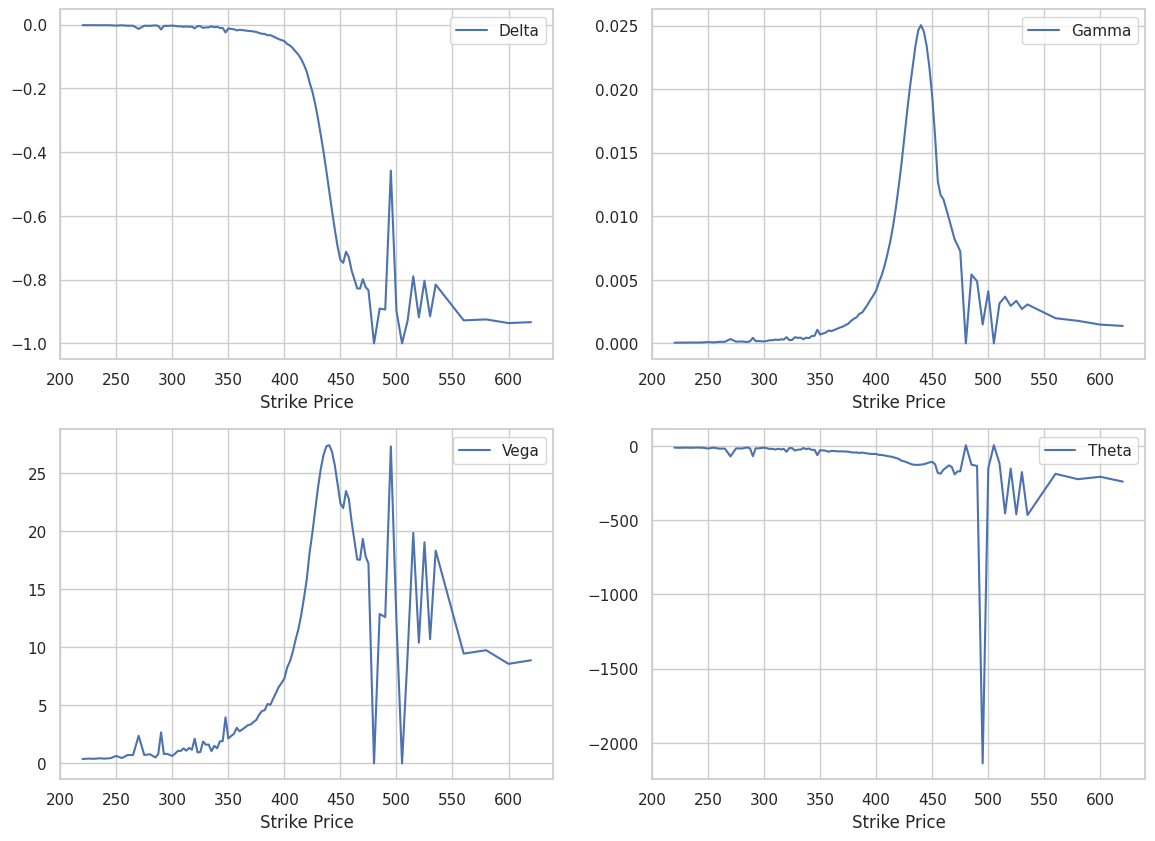

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(puts['strike'], puts['delta'], label='Delta')
axs[0, 1].plot(puts['strike'], puts['gamma'], label='Gamma')
axs[1, 0].plot(puts['strike'], puts['vega'], label='Vega')
axs[1, 1].plot(puts['strike'], puts['theta'], label='Theta')

for ax in axs.flat:
    ax.set_xlabel('Strike Price')
    ax.legend()

Next, we analyze how each of the 4 Greeks change when varying implied volatility, for both call and put options.

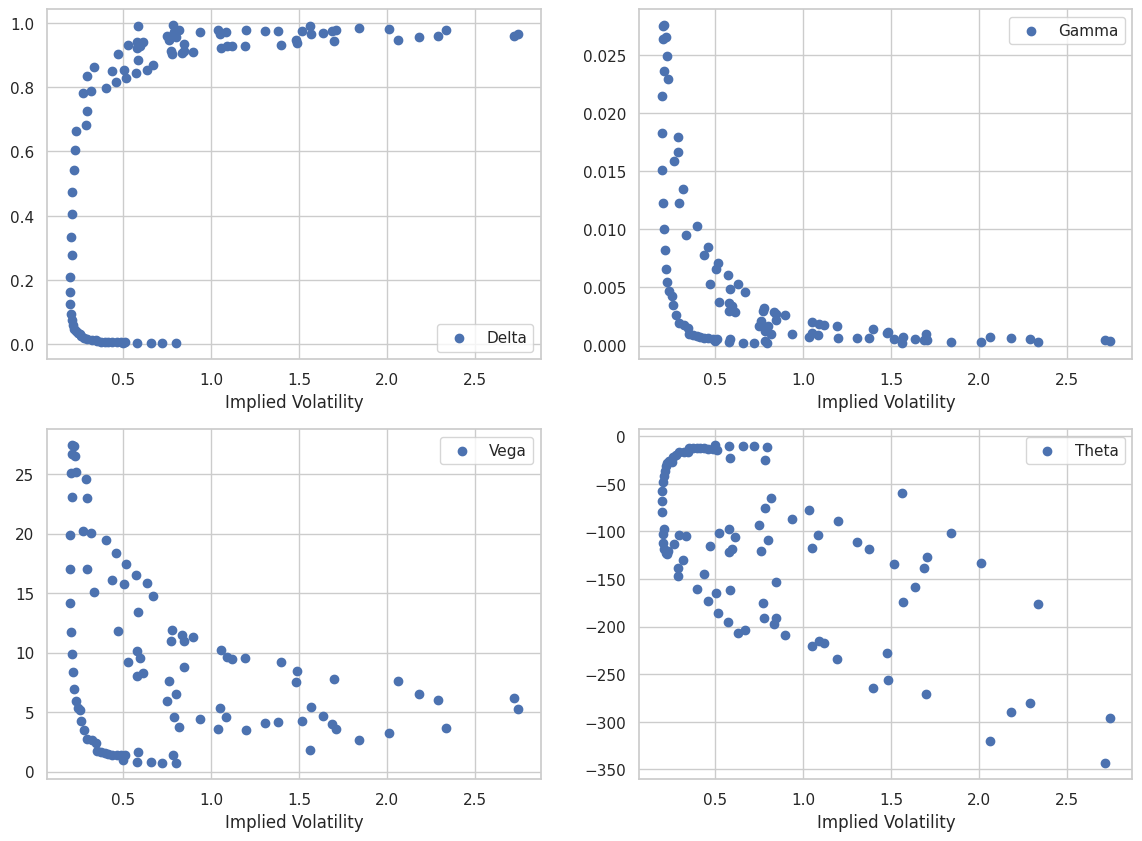

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].scatter(calls['impliedVolatility'], calls['delta'], label='Delta')
axs[0, 1].scatter(calls['impliedVolatility'], calls['gamma'], label='Gamma')
axs[1, 0].scatter(calls['impliedVolatility'], calls['vega'], label='Vega')
axs[1, 1].scatter(calls['impliedVolatility'], calls['theta'], label='Theta')

for ax in axs.flat:
    ax.set_xlabel('Implied Volatility')
    ax.legend()

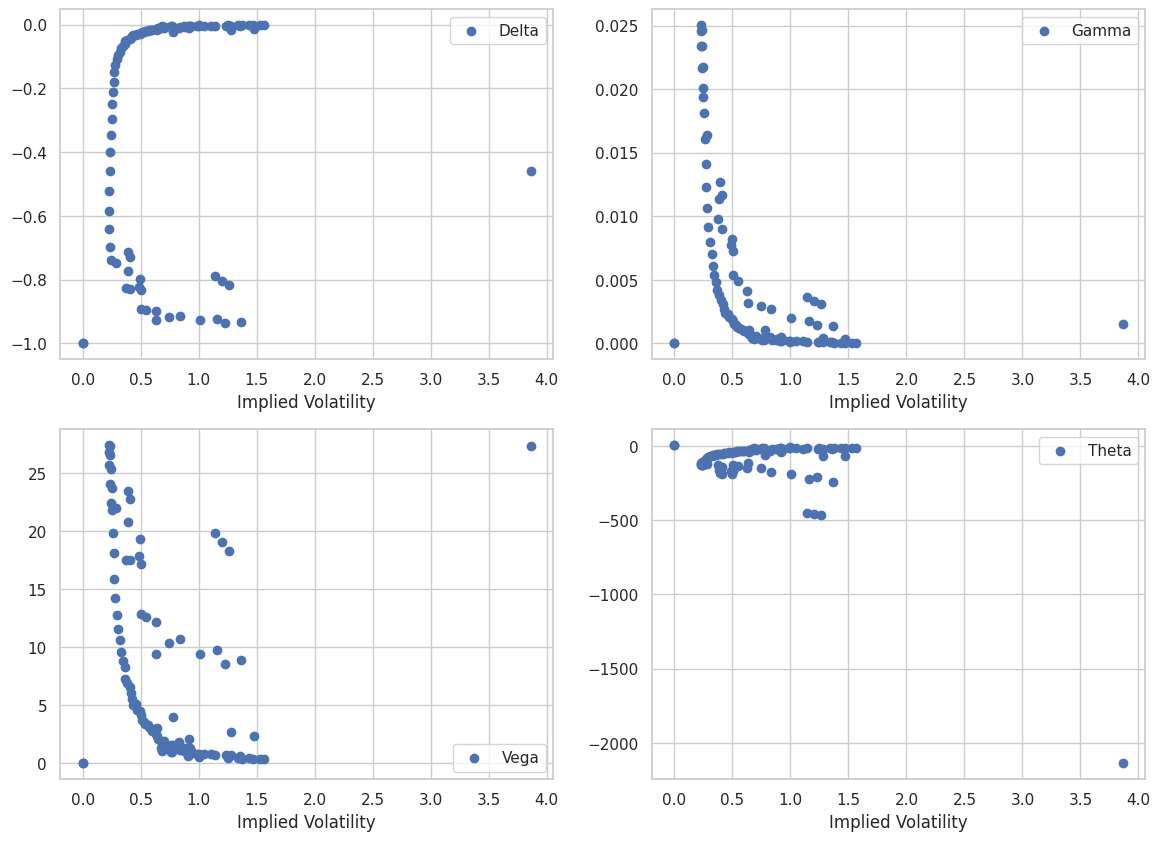

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].scatter(puts['impliedVolatility'], puts['delta'], label='Delta')
axs[0, 1].scatter(puts['impliedVolatility'], puts['gamma'], label='Gamma')
axs[1, 0].scatter(puts['impliedVolatility'], puts['vega'], label='Vega')
axs[1, 1].scatter(puts['impliedVolatility'], puts['theta'], label='Theta')

for ax in axs.flat:
    ax.set_xlabel('Implied Volatility')
    ax.legend()

## Part 3 - Sensitivity Analysis

This section will serve as the main exploratory analysis of this entire notebook; here, we will examine *how each Greek responds to changing*:
* S (while holding T and σ constant)
* T (while holding S and σ constant)
* σ (while holding S and T constant)  

To reiterate, S represents the underlying asset price, T represents the time to maturity, and σ represents the implied volatility.

The previous part showed 3D plots of joint dependencies (i.e., the Greeks as a function of 2 variables - either S x σ or S x T.) Here, we will focus on single-variable, 2D plots.

We begin with call options:

In [34]:
# 2D Greek plots wrt changing S (holding T and σ constant)
S_vals = np.linspace(50, 150, 200)
delta_s_call = [delta(S, K, 0.5, r, 0.2, "call") for S in S_vals]
gamma_s_call = [gamma(S, K, 0.5, r, 0.2) for S in S_vals]
vega_s_call = [vega(S, K, 0.5, r, 0.2) for S in S_vals]
theta_s_call = [theta(S, K, 0.5, r, 0.2, "call") for S in S_vals]

In [35]:
# 2D Greek plots wrt changing T (holding S and σ constant)
T_vals = np.linspace(0.01, 1.0, 200)
delta_t_call = [delta(100, K, T, r, 0.2, "call") for T in T_vals]
gamma_t_call = [gamma(100, K, T, r, 0.2) for T in T_vals]
vega_t_call = [vega(100, K, T, r, 0.2) for T in T_vals]
theta_t_call = [theta(100, K, T, r, 0.2, "call") for T in T_vals]

In [36]:
# 2D Greek plots wrt changing σ (holding S and T constant)
sigma_vals = np.linspace(0.05, 0.5, 200)
delta_sigma_call = [delta(100, K, 0.5, r, sigma, "call") for sigma in sigma_vals]
gamma_sigma_call = [gamma(100, K, 0.5, r, sigma) for sigma in sigma_vals]
vega_sigma_call = [vega(100, K, 0.5, r, sigma) for sigma in sigma_vals]
theta_sigma_call = [theta(100, K, 0.5, r, sigma, "call") for sigma in sigma_vals]

Now, we can visualize the plots created above as follows:

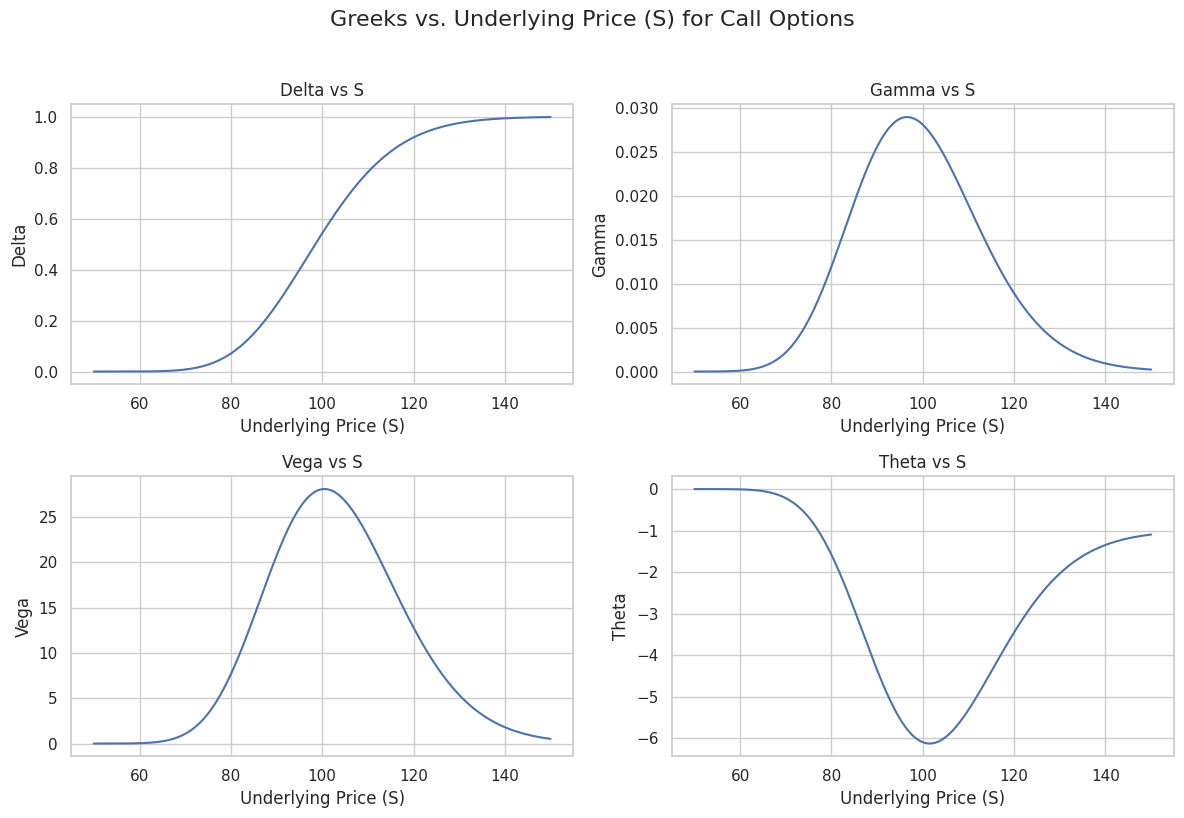

In [37]:
# 2D Greek plots vs Underlying Price (S)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(S_vals, delta_s_call)
axs[0, 0].set_title('Delta vs S')
axs[0, 0].set_xlabel('Underlying Price (S)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(S_vals, gamma_s_call)
axs[0, 1].set_title('Gamma vs S')
axs[0, 1].set_xlabel('Underlying Price (S)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(S_vals, vega_s_call)
axs[1, 0].set_title('Vega vs S')
axs[1, 0].set_xlabel('Underlying Price (S)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(S_vals, theta_s_call)
axs[1, 1].set_title('Theta vs S')
axs[1, 1].set_xlabel('Underlying Price (S)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Underlying Price (S) for Call Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

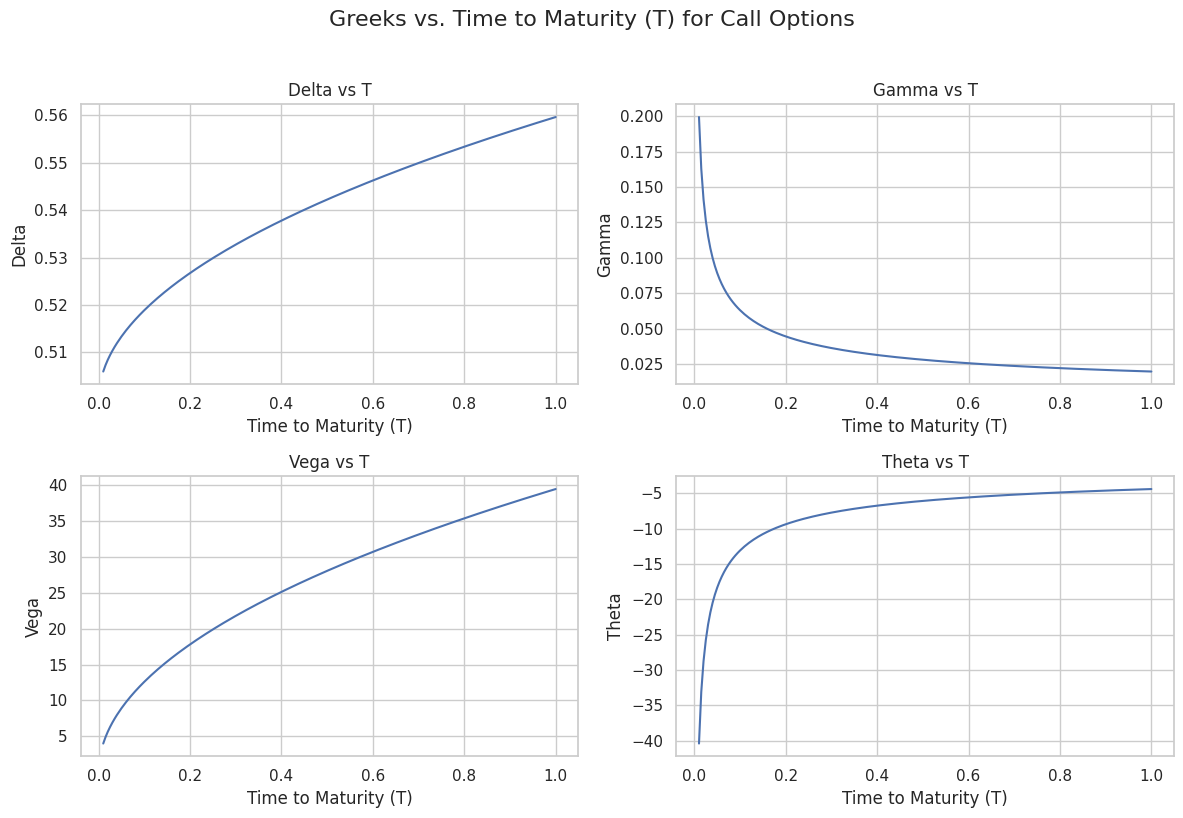

In [38]:
# 2D Greek plots vs Time to Maturity (T)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(T_vals, delta_t_call)
axs[0, 0].set_title('Delta vs T')
axs[0, 0].set_xlabel('Time to Maturity (T)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(T_vals, gamma_t_call)
axs[0, 1].set_title('Gamma vs T')
axs[0, 1].set_xlabel('Time to Maturity (T)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(T_vals, vega_t_call)
axs[1, 0].set_title('Vega vs T')
axs[1, 0].set_xlabel('Time to Maturity (T)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(T_vals, theta_t_call)
axs[1, 1].set_title('Theta vs T')
axs[1, 1].set_xlabel('Time to Maturity (T)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Time to Maturity (T) for Call Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

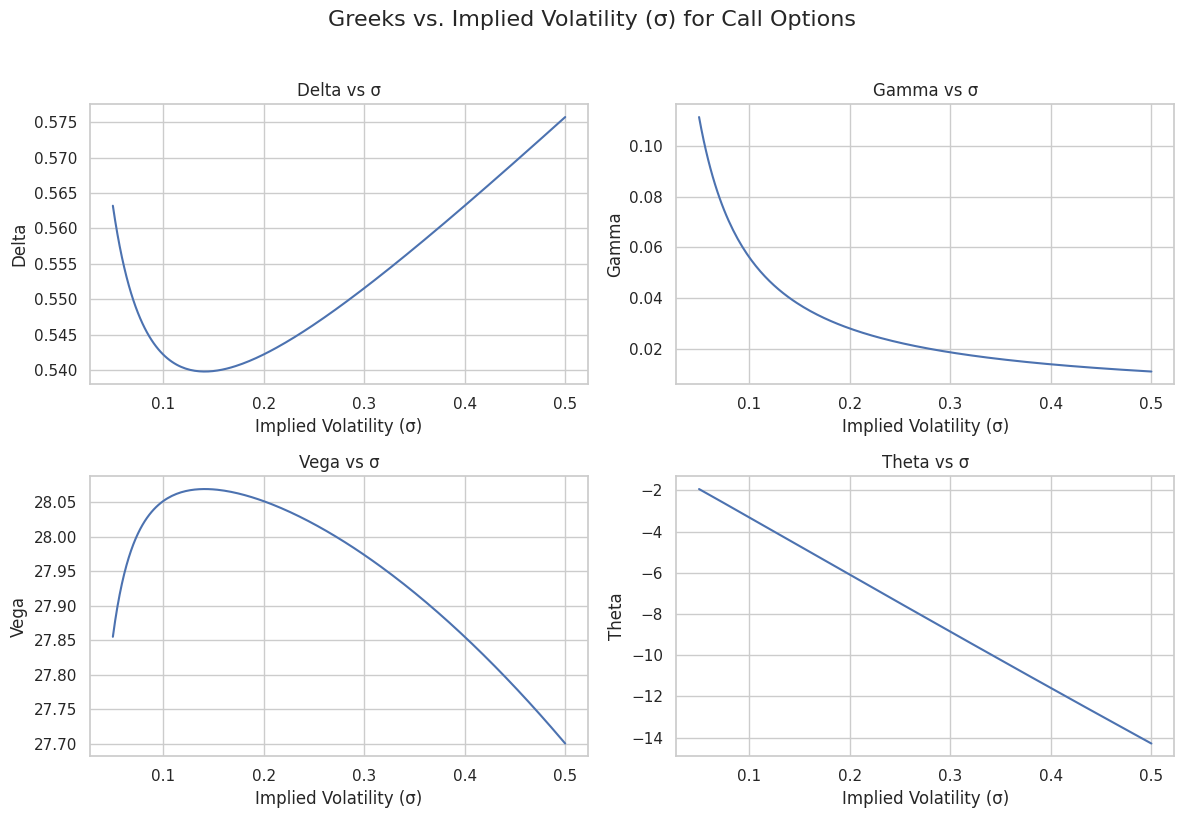

In [39]:
# 2D Greek plots vs Implied Volatility (σ)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(sigma_vals, delta_sigma_call)
axs[0, 0].set_title('Delta vs σ')
axs[0, 0].set_xlabel('Implied Volatility (σ)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(sigma_vals, gamma_sigma_call)
axs[0, 1].set_title('Gamma vs σ')
axs[0, 1].set_xlabel('Implied Volatility (σ)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(sigma_vals, vega_sigma_call)
axs[1, 0].set_title('Vega vs σ')
axs[1, 0].set_xlabel('Implied Volatility (σ)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(sigma_vals, theta_sigma_call)
axs[1, 1].set_title('Theta vs σ')
axs[1, 1].set_xlabel('Implied Volatility (σ)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Implied Volatility (σ) for Call Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

We can now do the same thing with put options:

In [40]:
# 2D Greek plots wrt changing S (holding T and σ constant)
delta_s_put = [delta(S, K, 0.5, r, 0.2, "put") for S in S_vals]
gamma_s_put = [gamma(S, K, 0.5, r, 0.2) for S in S_vals]
vega_s_put = [vega(S, K, 0.5, r, 0.2) for S in S_vals]
theta_s_put = [theta(S, K, 0.5, r, 0.2, "put") for S in S_vals]

In [41]:
# 2D Greek plots wrt changing T (holding S and σ constant)
delta_t_put = [delta(100, K, T, r, 0.2, "put") for T in T_vals]
gamma_t_put = [gamma(100, K, T, r, 0.2) for T in T_vals]
vega_t_put = [vega(100, K, T, r, 0.2) for T in T_vals]
theta_t_put = [theta(100, K, T, r, 0.2, "put") for T in T_vals]

In [42]:
# 2D Greek plots wrt changing σ (holding S and T constant)
delta_sigma_put = [delta(100, K, 0.5, r, sigma, "put") for sigma in sigma_vals]
gamma_sigma_put = [gamma(100, K, 0.5, r, sigma) for sigma in sigma_vals]
vega_sigma_put = [vega(100, K, 0.5, r, sigma) for sigma in sigma_vals]
theta_sigma_put = [theta(100, K, 0.5, r, sigma, "put") for sigma in sigma_vals]

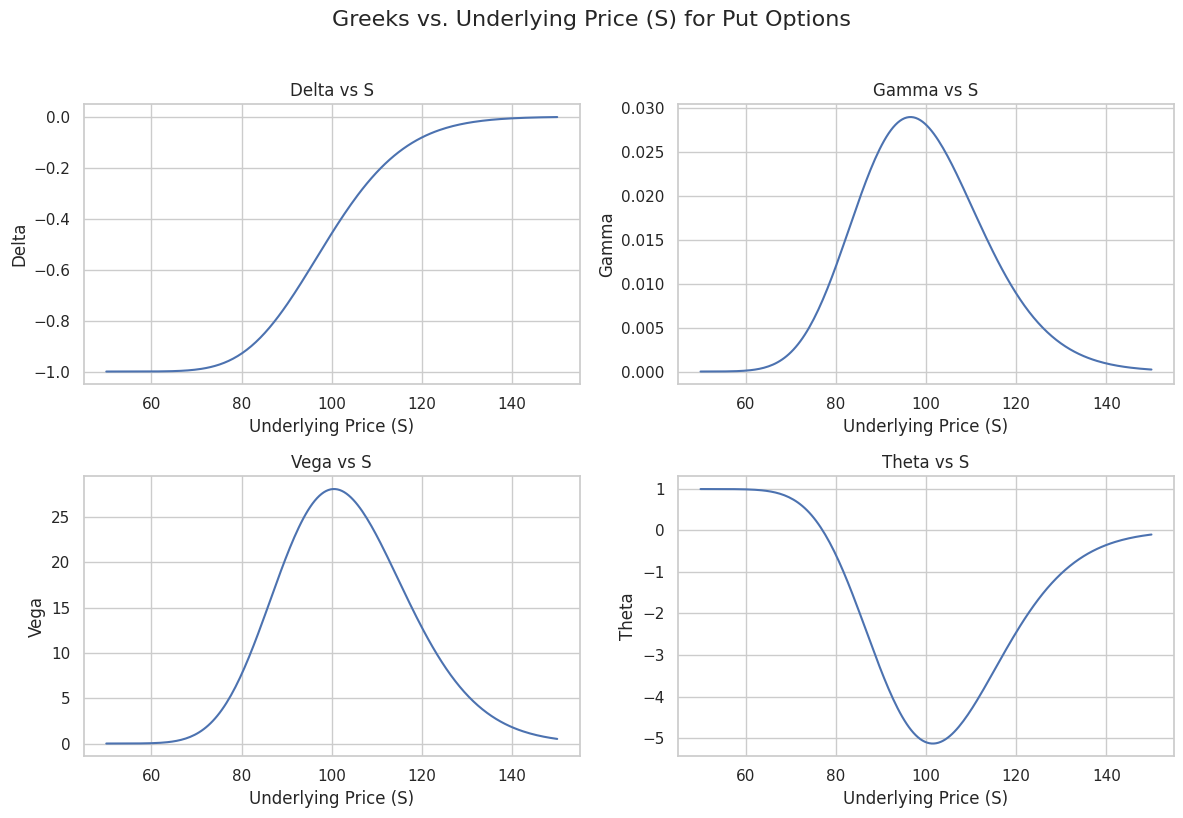

In [43]:
# 2D Greek plots vs Underlying Price (S)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(S_vals, delta_s_put)
axs[0, 0].set_title('Delta vs S')
axs[0, 0].set_xlabel('Underlying Price (S)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(S_vals, gamma_s_put)
axs[0, 1].set_title('Gamma vs S')
axs[0, 1].set_xlabel('Underlying Price (S)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(S_vals, vega_s_put)
axs[1, 0].set_title('Vega vs S')
axs[1, 0].set_xlabel('Underlying Price (S)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(S_vals, theta_s_put)
axs[1, 1].set_title('Theta vs S')
axs[1, 1].set_xlabel('Underlying Price (S)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Underlying Price (S) for Put Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

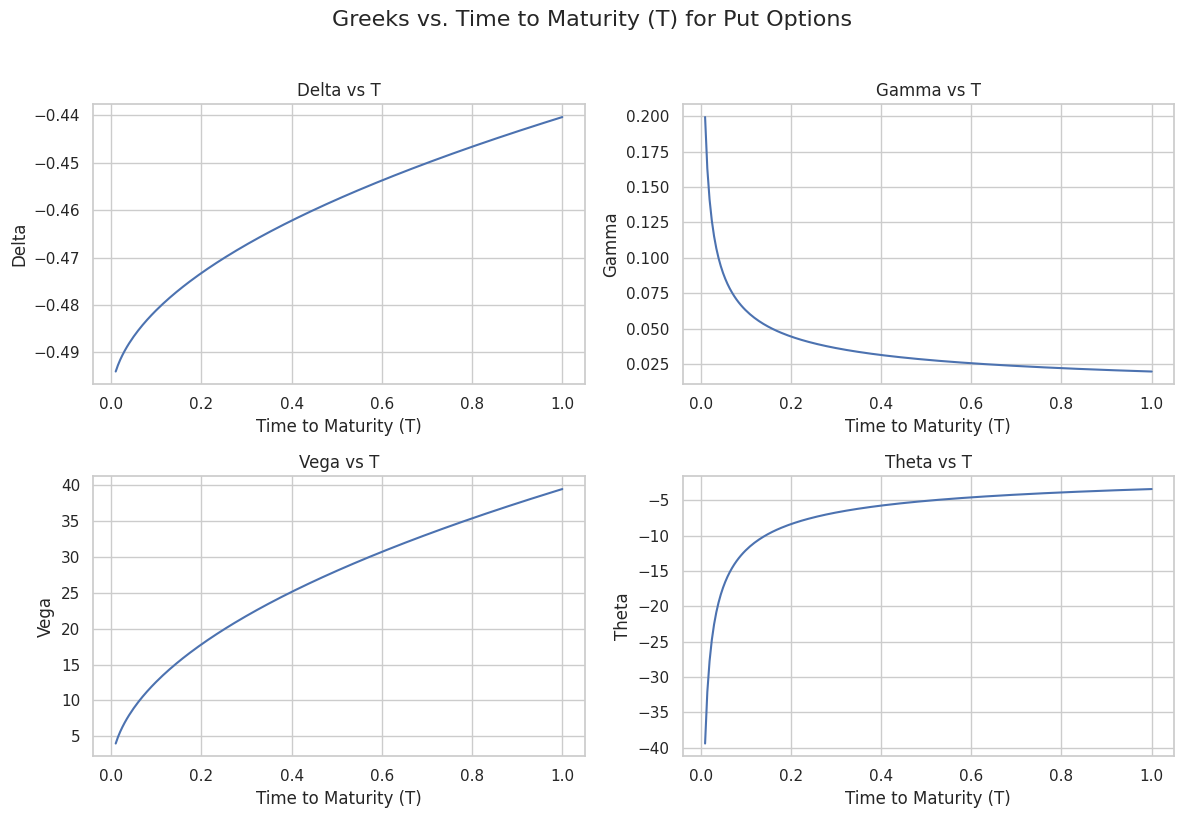

In [44]:
# 2D Greek plots vs Time to Maturity (T)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(T_vals, delta_t_put)
axs[0, 0].set_title('Delta vs T')
axs[0, 0].set_xlabel('Time to Maturity (T)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(T_vals, gamma_t_put)
axs[0, 1].set_title('Gamma vs T')
axs[0, 1].set_xlabel('Time to Maturity (T)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(T_vals, vega_t_put)
axs[1, 0].set_title('Vega vs T')
axs[1, 0].set_xlabel('Time to Maturity (T)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(T_vals, theta_t_put)
axs[1, 1].set_title('Theta vs T')
axs[1, 1].set_xlabel('Time to Maturity (T)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Time to Maturity (T) for Put Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

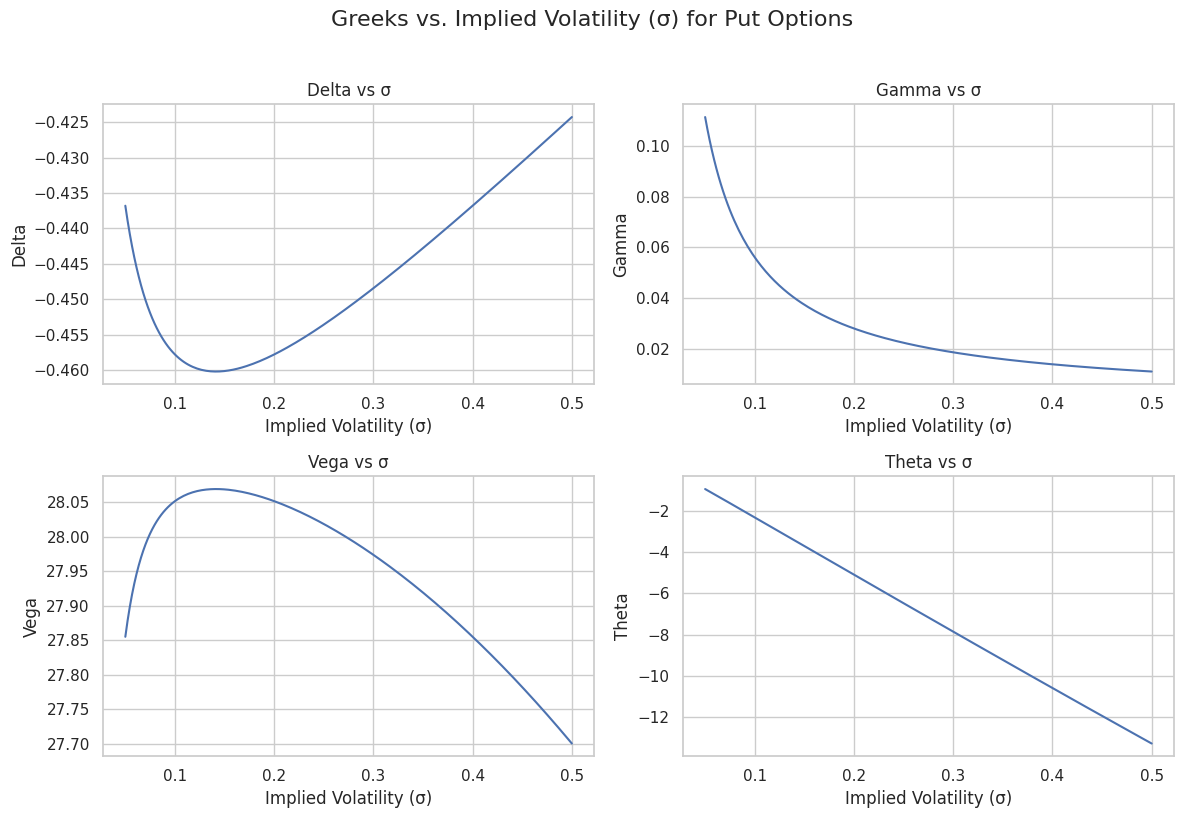

In [45]:
# 2D Greek plots vs Implied Volatility (σ)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(sigma_vals, delta_sigma_put)
axs[0, 0].set_title('Delta vs σ')
axs[0, 0].set_xlabel('Implied Volatility (σ)')
axs[0, 0].set_ylabel('Delta')

axs[0, 1].plot(sigma_vals, gamma_sigma_put)
axs[0, 1].set_title('Gamma vs σ')
axs[0, 1].set_xlabel('Implied Volatility (σ)')
axs[0, 1].set_ylabel('Gamma')

axs[1, 0].plot(sigma_vals, vega_sigma_put)
axs[1, 0].set_title('Vega vs σ')
axs[1, 0].set_xlabel('Implied Volatility (σ)')
axs[1, 0].set_ylabel('Vega')

axs[1, 1].plot(sigma_vals, theta_sigma_put)
axs[1, 1].set_title('Theta vs σ')
axs[1, 1].set_xlabel('Implied Volatility (σ)')
axs[1, 1].set_ylabel('Theta')

fig.suptitle("Greeks vs. Implied Volatility (σ) for Put Options", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Part 4 - Sample Regression Fit

### Polynomial Regression for Simulated Delta (S x σ)

In this section, we aim to approximate the behavior of **Delta** using a **second-order polynomial regression model** over simulated values of the underlying asset price \( S \) and implied volatility \( σ \).

Specifically, we will model Delta as a parametric surface of the form:

Δ(S, σ) ≈ a_0 + a_1 S + a_2 σ + a_3 S^2 + a_4 σ^2 + a_5 S ⋅ σ


This allows us to:
- Quantify how well a low-degree parametric model captures the structure of the Greek.
- Evaluate model performance via R^2.
- Compare the predicted surface to the true Black-Scholes Delta values.

In [46]:
X = np.column_stack((S_mesh.flatten(), sigma_mesh.flatten()))
y = delta_s_sigma_call.flatten()

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

In [48]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

In [49]:
print(f"R² Score: {model.score(X_poly, y):.4f}")

R² Score: 0.9413


In [50]:
y_pred = model.predict(X_poly).reshape(S_mesh.shape)

In [51]:
print(y_pred.shape)

(50, 50)


In [52]:
import plotly.graph_objects as go

fig = go.Figure()

# Predicted Delta surface
fig.add_trace(go.Surface(
    x=S_mesh,
    y=sigma_mesh,
    z=y_pred.reshape(S_mesh.shape),
    colorscale='Viridis',
    name='Fitted Delta Surface',
    showscale=True,
    colorbar=dict(title='Delta (Predicted)')
))

# Layout tweaks
fig.update_layout(
    title='Fitted Polynomial Delta Surface (S × σ) for Call Options',
    scene=dict(
        xaxis_title='Underlying Price (S)',
        yaxis_title='Implied Volatility (σ)',
        zaxis_title='Predicted Delta'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

## Part 5 - Real-World Use Cases (Web App Preview)

The 2D and 3D visualizations above already highlight key option behavior under varying market conditions. To explore how traders act on these sensitivities (e.g., Gamma hedging, Theta burn, Vega exposure), an interactive simulation tool is more appropriate.

This analysis will be extended in the companion Streamlit web app, where users can:
- Simulate trades and Greek exposure dynamically
- Explore hedging strategies and decay under live or historical conditions
- Compare real-world options to Black-Scholes-based estimates